In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
import torch
import torchvision
print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")

torch version: 1.13.0+cu117
torchvision version: 0.14.0+cu117


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision
from dataloaders import data_setup, engine
from torch import nn
from torchvision import transforms
from torchinfo import summary


In [3]:
torch.cuda.empty_cache()

In [4]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Get data

Before we can start to use **transfer learning**, we will set up the dataset into DataLoaders

In [5]:
import os
import zipfile

from pathlib import Path

import requests

# Setup path to data folder
path = "S:/galaxydata/"
data_path = Path(path)
image_path = data_path / "data"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")


S:\galaxydata\data directory exists.


In [6]:
# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

## Create Datasets and DataLoaders



In [7]:
# Create a transforms pipeline manually (required for torchvision < 0.13)
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [8]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x2a3d4ef7b20>,
 ['Disk, Edge-on, Boxy Bulge',
  'Disk, Edge-on, No Bulge',
  'Disk, Face-on, Loose Spiral',
  'Disk, Face-on, Medium Spiral',
  'Disk, Face-on, No Spiral',
  'Disk, Face-on, Tight Spiral',
  'Smooth, Cigar shaped',
  'Smooth, Completely round',
  'Smooth, in-between round'])

### Creating a transform for `torchvision.models` 



In [9]:
# Get a set of pretrained model weights
weights = torchvision.models.ViT_B_16_Weights.IMAGENET1K_V1 # .DEFAULT = best available weights from pretraining on ImageNet
weights

ViT_B_16_Weights.IMAGENET1K_V1

In [10]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [11]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms, # perform same data transforms on our own data as the pretrained model
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x2a3d4f10880>,
 ['Disk, Edge-on, Boxy Bulge',
  'Disk, Edge-on, No Bulge',
  'Disk, Face-on, Loose Spiral',
  'Disk, Face-on, Medium Spiral',
  'Disk, Face-on, No Spiral',
  'Disk, Face-on, Tight Spiral',
  'Smooth, Cigar shaped',
  'Smooth, Completely round',
  'Smooth, in-between round'])

## Getting a pretrained model


Here we use the base Vision Transformer Architecture from the <i><b>An Image is Worth 16x16 Words</i></b> paper

In [12]:
# NEW: Setup the model with pretrained weights and send it to the target device (torchvision v0.13+)
weights = torchvision.models.ViT_B_16_Weights.IMAGENET1K_V1
model = torchvision.models.vit_b_16(weights = weights, progress = False).to(device)

model

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

### Getting a summary of our model with `torchinfo.summary()`

We use torchinfo to learn more about the model we are using:
To do so, we'll pass in:
 * `model` - the model we'd like to get a summary of.
 * `input_size` - the shape of the data we'd like to pass to our model.
 * `col_names` - the various information columns we'd like to see about our model. 
 * `col_width` - how wide the columns should be for the summary.
 * `row_settings` - what features to show in a row.

In [13]:
# Print a summary using torchinfo (uncomment for actual output)
input_size = (32, 3, 224, 224)
summary(model=model, 
        input_size= input_size, 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=10,
        row_settings=["var_names"]
) 

Layer (type (var_name))                                      Input Shape Output Shape Param #    Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224] [32, 1000] 768        True
├─Conv2d (conv_proj)                                         [32, 3, 224, 224] [32, 768, 14, 14] 590,592    True
├─Encoder (encoder)                                          [32, 197, 768] [32, 197, 768] 151,296    True
│    └─Dropout (dropout)                                     [32, 197, 768] [32, 197, 768] --         --
│    └─Sequential (layers)                                   [32, 197, 768] [32, 197, 768] --         True
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768] [32, 197, 768] 7,087,872  True
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768] [32, 197, 768] 7,087,872  True
│    │    └─EncoderBlock (encoder_layer_2)                   [32, 197, 768] [32, 197, 768] 7,087,872  True
│    │    └─EncoderBlock (encoder_

### Freezing the base model and changing the output layer to suit our needs



In [14]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model.encoder.parameters():
    param.requires_grad = False

In [15]:
# for name, layer in model.named_modules():
#     if isinstance(layer, torch.nn.Dropout):
#          layer.p = 0.1

In [16]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.heads = torch.nn.Sequential(
    torch.nn.Linear(in_features=768, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

#Change output classes to Astronomy classes
weights.meta['categories'] = class_names

In [17]:
# # Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(model, 
        input_size= input_size, # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=10,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape Output Shape Param #    Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224] [32, 9]    768        Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224] [32, 768, 14, 14] 590,592    True
├─Encoder (encoder)                                          [32, 197, 768] [32, 197, 768] 151,296    False
│    └─Dropout (dropout)                                     [32, 197, 768] [32, 197, 768] --         --
│    └─Sequential (layers)                                   [32, 197, 768] [32, 197, 768] --         False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768] [32, 197, 768] (7,087,872) False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768] [32, 197, 768] (7,087,872) False
│    │    └─EncoderBlock (encoder_layer_2)                   [32, 197, 768] [32, 197, 768] (7,087,872) False
│    │    └─EncoderBloc

Here, we see that <i>Trainable</i> is set to False except for the final layer of the model

In [18]:
import torchinfo 
torchinfo.summary(model, input_size= input_size)

Layer (type:depth-idx)                        Output Shape              Param #
VisionTransformer                             [32, 9]                   768
├─Conv2d: 1-1                                 [32, 768, 14, 14]         590,592
├─Encoder: 1-2                                [32, 197, 768]            151,296
│    └─Dropout: 2-1                           [32, 197, 768]            --
│    └─Sequential: 2-2                        [32, 197, 768]            --
│    │    └─EncoderBlock: 3-1                 [32, 197, 768]            (7,087,872)
│    │    └─EncoderBlock: 3-2                 [32, 197, 768]            (7,087,872)
│    │    └─EncoderBlock: 3-3                 [32, 197, 768]            (7,087,872)
│    │    └─EncoderBlock: 3-4                 [32, 197, 768]            (7,087,872)
│    │    └─EncoderBlock: 3-5                 [32, 197, 768]            (7,087,872)
│    │    └─EncoderBlock: 3-6                 [32, 197, 768]            (7,087,872)
│    │    └─EncoderBlock: 3-7 

## Train model



In [19]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)

In [20]:
# Set the random seeds
torch.manual_seed(50)
torch.cuda.manual_seed(50)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=40,
                       patience=3,
                       delta=1,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {(end_time-start_time)/60:.3f} minutes")
print(f"[INFO] Total training time: {(end_time-start_time)/3600:.3f} hours")

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.6869 | train_acc: 0.3995 | test_loss: 1.3813 | test_acc: 0.5085 | min_test_loss: 1.3813 | counter: 0.0000 |
Epoch: 2 | train_loss: 1.3279 | train_acc: 0.5249 | test_loss: 1.2308 | test_acc: 0.5605 | min_test_loss: 1.2308 | counter: 0.0000 |
Epoch: 3 | train_loss: 1.1973 | train_acc: 0.5775 | test_loss: 1.1658 | test_acc: 0.5923 | min_test_loss: 1.1658 | counter: 0.0000 |
Epoch: 4 | train_loss: 1.1244 | train_acc: 0.6009 | test_loss: 1.0617 | test_acc: 0.6315 | min_test_loss: 1.0617 | counter: 0.0000 |
Epoch: 5 | train_loss: 1.0363 | train_acc: 0.6357 | test_loss: 1.0363 | test_acc: 0.6405 | min_test_loss: 1.0363 | counter: 0.0000 |
Epoch: 6 | train_loss: 0.9853 | train_acc: 0.6480 | test_loss: 1.0828 | test_acc: 0.6149 | min_test_loss: 1.0363 | counter: 0.0000 |
Epoch: 7 | train_loss: 0.9398 | train_acc: 0.6697 | test_loss: 0.9981 | test_acc: 0.6437 | min_test_loss: 0.9981 | counter: 0.0000 |
Epoch: 8 | train_loss: 0.9139 | train_acc: 0.6752 | test_loss: 0.9779

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000002A3D2607940>
Traceback (most recent call last):
  File "C:\Users\kumar\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\utils\data\dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "C:\Users\kumar\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\utils\data\dataloader.py", line 1424, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


[INFO] Total training time: 56.856 minutes
[INFO] Total training time: 0.948 hours


## Evaluate model by plotting loss curves

We can plot the loss curves using the `plot_loss_curves` function from the `helper_functions.py`script 

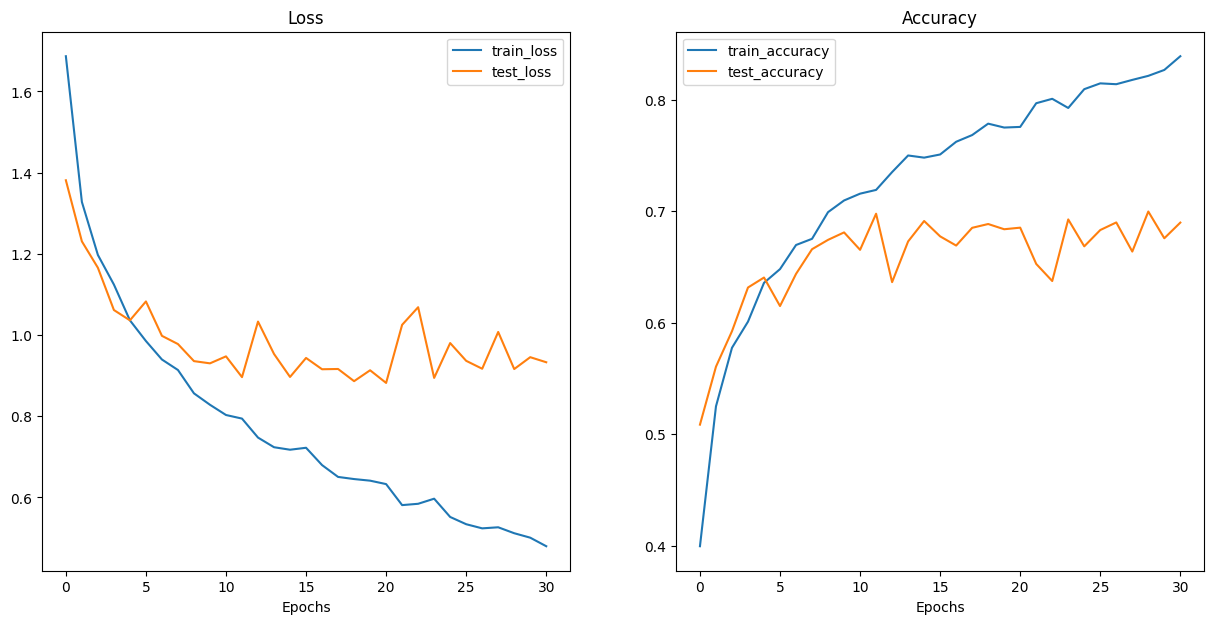

In [23]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
from helper_functions import plot_loss_curves

plot_loss_curves(results)

In [24]:
model_path = "C:/Users/kumar/University of Hartford/Thesis/models/visiontransformer/vit_40.pth"
engine.save_model(model, model_path)

results_path = "C:/Users/kumar/University of Hartford/Thesis/models/visiontransformer/results_40.npy"
engine.save_results(results, results_path)